In [ ]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from utils.data_io import create_time_bins, get_cam_timestamps, load_ONE, get_experiment_identifiers, get_dlc_df, get_rotary_position, temporally_align_variable, preprocess_dlc_data
from utils.behavioral_analysis import calculate_median_position
from utils.visualization import plot_single_session, plot_all_sessions, plot_sorted_spike_counts, plot_PCA, plot_correlation_distributions, plot_dlc_analyses, plot_reliability_stability
from utils.pipeline import load_session_data, analyze_single_session, analyze_multiple_sessions
from utils.correlation_analysis import run_PCA, get_correlations
from utils.decoding_analysis import split_data_for_decoding, train_decoder, test_decoder_cross_context, test_decoder_within_context, compare_within_cross_context_decoding, calculate_weight_vector_cosine_similarity, plot_weights, calculate_r2_leaveout
import matplotlib.pyplot as plt
import pandas as pd
from types import SimpleNamespace as Bunch
import seaborn as sns
from scipy.stats import binned_statistic_2d
from IPython.display import display
import numpy as np
import pandas as pd
import os
import glob
from scipy.io import loadmat
from pinkrigs_tools.dataset.query import load_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
subject_id = "AV043"
my_sessions = [
    ('AV043', '2024-03-04'),
    ('AV043', '2024-03-05'),
    #('AV043', '2024-03-08'),# DLC for only 5 min
    #('AV043', '2024-03-11'),  # neural recordings start only half way through
    ('AV043', '2024-03-12'), #no spikes will use as behavior baseline
    ('AV043', '2024-03-13'),
    ('AV043', '2024-03-14'),
    ('AV043', '2024-03-26'), # no spikes will use as behavior baseline
    ('EB036', '2024-03-20'),
    ('EB036', '2024-03-22'),
    ('EB037', '2024-03-20'),
    ('EB037', '2024-03-21'),
    ('EB037', '2024-03-22'),
    ('GB011', '2024-05-09'),
    #('GB011', '2024-05-10'), # wheel not at all visited in second half 
    ('GB011', '2024-05-14'),
    ('GB011', '2024-05-15'),
    ('GB011', '2024-05-16'),
    ('GB011', '2024-05-17'),
    ('GB012', '2024-06-19'),
    ('GB012', '2024-06-20'),
    ('GB012', '2024-06-21'),
    ('GB012', '2024-06-25'),
    ('GB012', '2024-07-11'), # no spikes will use as behavior baseline
    #('GB012', '2024-07-12'), DLC for only half the sesssion
    ('GB012', '2024-07-16'),

    
]




    

In [ ]:
all_sessions = analyze_multiple_sessions(my_sessions)




No probe1 data found
Loaded and analyzed: AV043 - 2024-03-04
No probe1 data found
Loaded and analyzed: AV043 - 2024-03-05
No probe0 data found
No probe1 data found
Loaded and analyzed: AV043 - 2024-03-12
No probe1 data found
Loaded and analyzed: AV043 - 2024-03-13
No probe1 data found
Loaded and analyzed: AV043 - 2024-03-14
No probe0 data found
No probe1 data found
Loaded and analyzed: AV043 - 2024-03-26
Loaded and analyzed: EB036 - 2024-03-20
Loaded and analyzed: EB036 - 2024-03-22
Loaded and analyzed: EB037 - 2024-03-20
Loaded and analyzed: EB037 - 2024-03-21
Loaded and analyzed: EB037 - 2024-03-22
Loaded and analyzed: GB011 - 2024-05-09
Loaded and analyzed: GB011 - 2024-05-14
Loaded and analyzed: GB011 - 2024-05-15
Loaded and analyzed: GB011 - 2024-05-16
Loaded and analyzed: GB011 - 2024-05-17
Loaded and analyzed: GB012 - 2024-06-19
Loaded and analyzed: GB012 - 2024-06-20
Loaded and analyzed: GB012 - 2024-06-21
Loaded and analyzed: GB012 - 2024-06-25
No probe0 data found
No probe1 d

ValueError: too many values to unpack (expected 2)

In [32]:
plot_all_sessions(all_sessions)

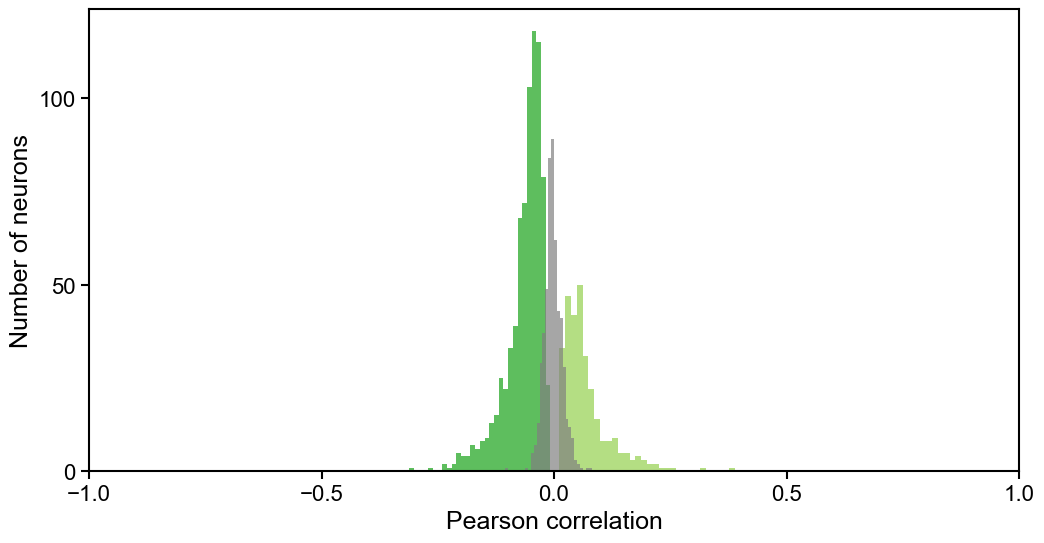

In [128]:
sesh = all_sessions[15]

p_vals_arena =sesh.p_vals_oa

arena_correlations = sesh.r_oa

arena_pos_mask = np.where((arena_correlations >0) & (p_vals_arena < 0.05))

arena_neg_mask = np.where((arena_correlations < 0) & (p_vals_arena < 0.05))

arena_neutral_mask = np.where( p_vals_arena > 0.05)

plt.figure(figsize=(12, 6))
plt.hist(arena_correlations[arena_pos_mask], alpha=0.7, color="#94D14F", bins=30)
plt.hist(arena_correlations[arena_neg_mask], alpha=0.7, color= "#1AA31A", bins=30)
plt.hist(arena_correlations[arena_neutral_mask], alpha=0.7, color="grey", bins=30)
plt.xlabel('Pearson correlation', fontsize=18)
plt.ylabel('Number of neurons', fontsize=18)
plt.xticks(np.arange(-1, 1.05, 0.5), fontsize=16)
plt.yticks(np.arange(0,100.05, 50), fontsize=16)
plt.show()

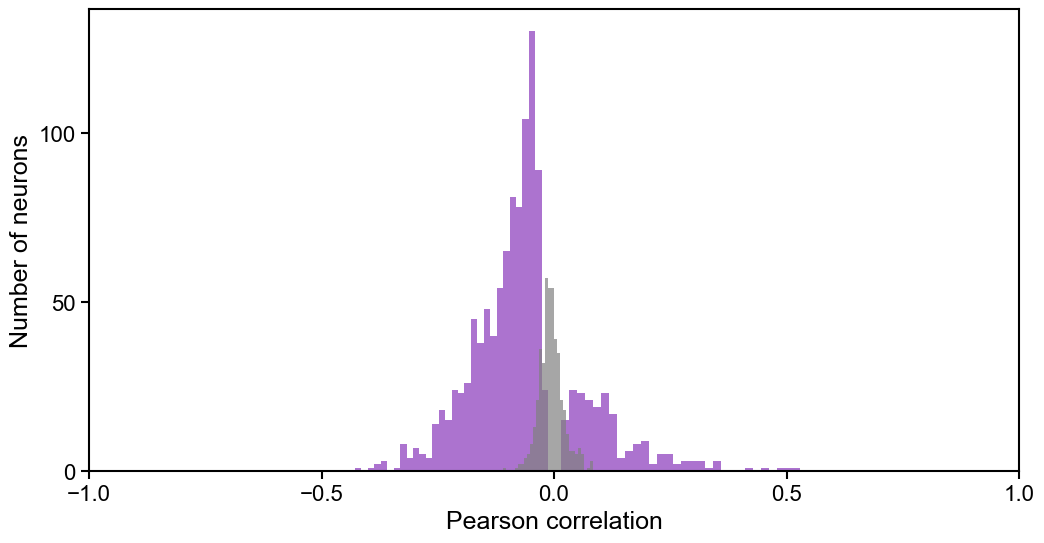

In [131]:
sesh = all_sessions[15]

p_vals_wheel =sesh.p_vals_wh

wheel_correlations = sesh.r_wh

wheel_pos_mask = np.where((wheel_correlations >0) & (p_vals_wheel < 0.05))

wheel_neg_mask = np.where((wheel_correlations < 0) & (p_vals_wheel < 0.05))

wheel_neutral_mask = np.where( p_vals_wheel > 0.05)

plt.figure(figsize=(12, 6))
plt.hist(wheel_correlations[wheel_pos_mask], alpha=0.7, color="#8938BB", bins=30)
plt.hist(wheel_correlations[wheel_neg_mask], alpha=0.7, color="#8938BB", bins=30)
plt.hist(wheel_correlations[wheel_neutral_mask], alpha=0.7, color="grey", bins=30)
plt.xlabel('Pearson correlation', fontsize=18)
plt.ylabel('Number of neurons', fontsize=18)
plt.xticks(np.arange(-1, 1.05, 0.5), fontsize=16)
plt.yticks(np.arange(0,100.05, 50), fontsize=16)
plt.show()

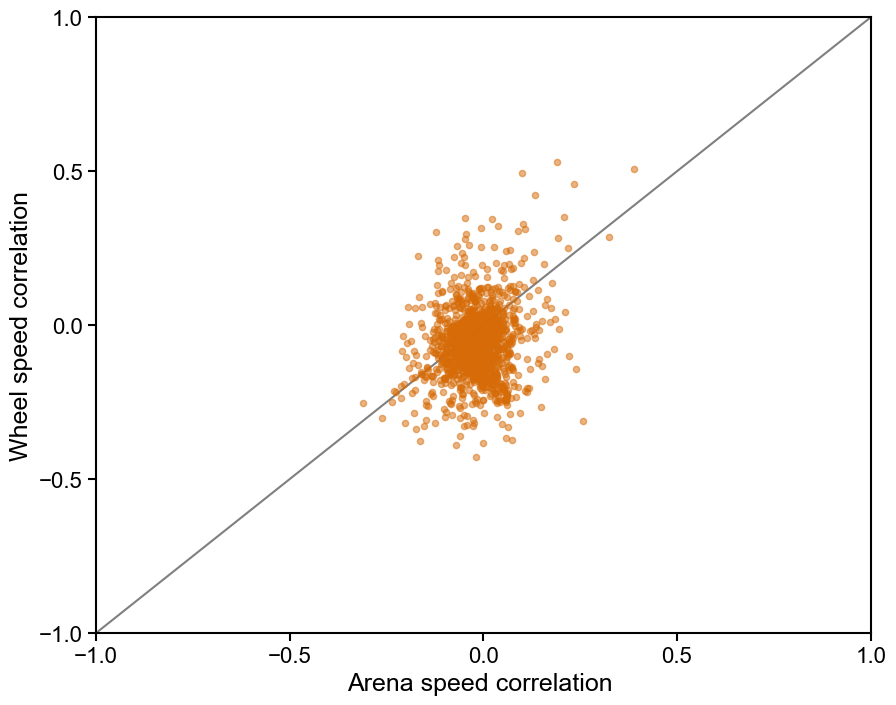

In [ ]:
sesh = all_sessions[15]

plt.figure(figsize=(10, 8))
plt.scatter(sesh.r_oa, sesh.r_wh, alpha=0.5, s=20, zorder=2, color="#D66B07")
plt.xlabel('Arena speed correlation ', fontsize=18)
plt.ylabel('Wheel speed correlation', fontsize=18)
plt.plot([-1, 1], [-1, 1], 'k-', linewidth=1.5, alpha=0.5, zorder=1)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xticks(np.arange(-1, 1.01, 0.5), fontsize=16)
plt.yticks(np.arange(-1, 1.01, 0.5), fontsize=16)
plt.show()

([<matplotlib.axis.YTick at 0x1b092435ba0>,
 [Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0')])

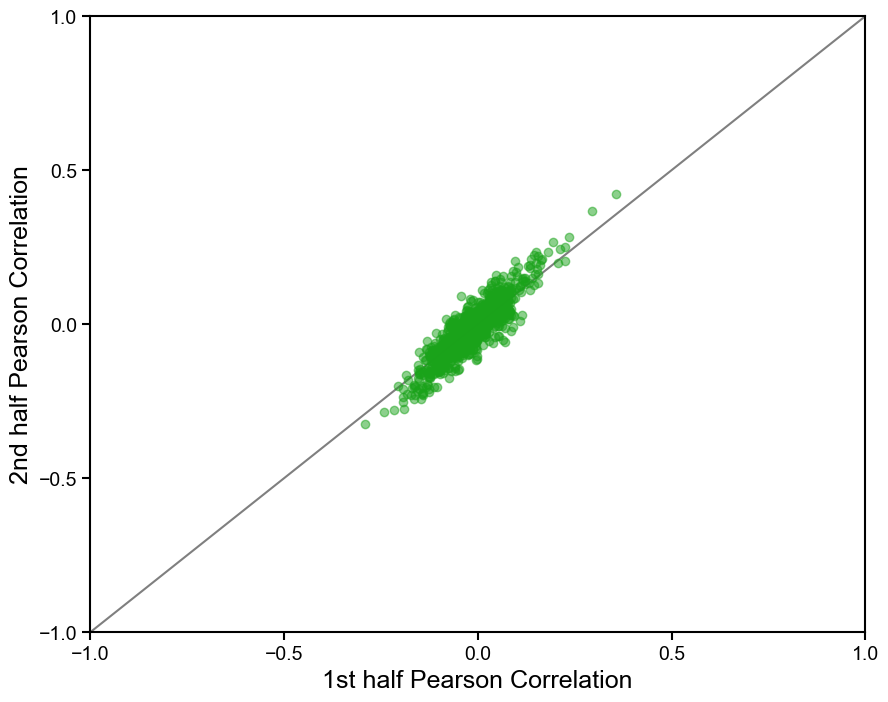

In [125]:
sesh = all_sessions[15]
plt.figure(figsize=(10, 8))
plt.scatter(sesh.r_oa_first_half, sesh.r_oa_second_half, alpha=0.5, color="#1AA31A", zorder=2)
plt.xlabel('1st half Pearson Correlation', fontsize=18)
plt.ylabel('2nd half Pearson Correlation', fontsize=18)
plt.plot([-1, 1], [-1, 1], 'k-', linewidth=1.5, alpha=0.5, zorder=1)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xticks(np.arange(-1, 1.01, 0.5))  
plt.yticks(np.arange(-1, 1.01, 0.5))  

([<matplotlib.axis.YTick at 0x1b096f1c400>,
 [Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0')])

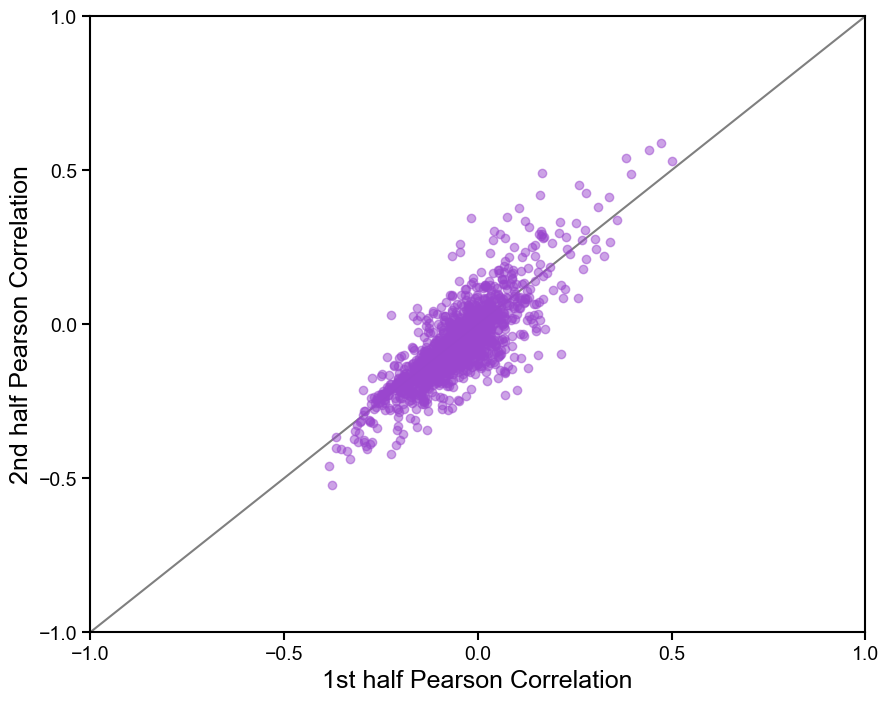

In [ ]:
sesh = all_sessions[15]
plt.figure(figsize=(10, 8))
plt.scatter(sesh.r_wh_first_half, sesh.r_wh_second_half, alpha=0.5, color=, zorder=2)
plt.xlabel('1st half Pearson Correlation', fontsize=18)
plt.ylabel('2nd half Pearson Correlation', fontsize=18)
plt.plot([-1, 1], [-1, 1], 'k-', linewidth=1.5, alpha=0.5, zorder=1)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xticks(np.arange(-1, 1.01, 0.5))  
plt.yticks(np.arange(-1, 1.01, 0.5)) 

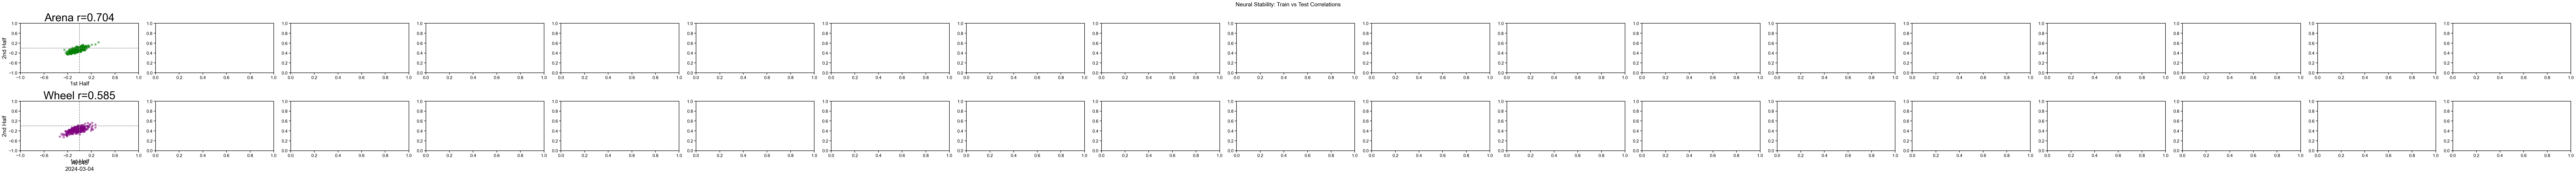

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
n_sessions = len(all_sessions)
standalone =  True 


fig, axes = plt.subplots(2, n_sessions, figsize=(6*n_sessions, 8))
    if n_sessions == 1:
        axes = axes.reshape(2, 1)


    axes[0, i].scatter(session.r_oa_first_half, session.r_oa_second_half, alpha=0.5, color='green')
    axes[0, i].axhline(0, color='gray', linestyle='--')
    axes[0, i].axvline(0, color='gray', linestyle='--')
    axes[0, i].set_xlim(-1, 1)
    axes[0, i].set_ylim(-1, 1)
    axes[0, i].set_xticks(np.arange(-1, 1.1, 0.4))  
    axes[0, i].set_yticks(np.arange(-1, 1.1, 0.4))  
        
    # Wheel stability
    axes[1, i].scatter(session.r_wh_first_half, session.r_wh_second_half, alpha=0.5, color='purple')
    axes[1, i].axhline(0, color='gray', linestyle='--')
    axes[1, i].axvline(0, color='gray', linestyle='--')
    axes[1, i].set_xlim(-1, 1)
    axes[1, i].set_ylim(-1, 1)
    axes[1, i].set_xticks(np.arange(-1, 1.1, 0.4))  
    axes[1, i].set_yticks(np.arange(-1, 1.1, 0.4))  
        
    axes[0, i].set_title(f'Arena r={session.oa_stability:.3f}', fontsize=35)
    axes[1, i].set_title(f'Wheel r={session.wh_stability:.3f}', fontsize=35)
        
    if i == 0:
        axes[0, i].set_ylabel('2nd Half', fontsize=18)
        axes[1, i].set_ylabel('2nd Half', fontsize=18)
        axes[0, i].set_xlabel('1st Half', fontsize=18)
        axes[1, i].set_xlabel('1st Half', fontsize=18)
    
    if standalone:
            
        axes[1, i].text(0, -1.4, f'{session.subject_id}\n{session.date}', 
                        ha='center', va='top', fontsize=18, transform=axes[1, i].transData)
    if standalone:
        plt.suptitle('Neural Stability: Train vs Test Correlations', fontsize=18)
        plt.tight_layout()
        plt.show()

In [ ]:
arena_correlations = sesh.r_oa

arena_pos_mask = np.where(np.sign(arena_correlations) >0)

arena_neg_mask = np.where(np.sign(arena_correlations) < 0)

arena_neutral_mask = np.where(np.sign(arena_correlations) == 0)

plt.figure(figsize=(12, 6))
plt.hist(arena_correlations[arena_pos_mask], alpha=0.7, color='#2E7D32')
plt.hist(arena_correlations[arena_neg_mask], alpha=0.7, color='#2E7D32' )
plt.hist(arena_correlations[arena_neutral_mask], alpha=0.7, color="grey")
plt.xlabel('Pearson correlation', fontsize=18)
plt.ylabel('Number of neurons', fontsize=18)
plt.xticks(np.arange(-1, 1, 0.5), fontsize=16)
plt.yticks(np.arange(0,150, 50), fontsize=16)
plt.show()

In [21]:
def get_reliability_stability(session):

        r_oa_1= session.r_oa_first_half
        r_oa_2 = session.r_oa_second_half
        r_wh_1= session.r_wh_first_half
        r_wh_2= session.r_wh_second_half
        r_oa_1_2 = session.oa_stability
        r_wh_1_2 = session.wh_stability


        r_oa_1_wh_2 = np.corrcoef(r_oa_1, r_wh_2) [0,1]
        r_oa_2_wh_1 = np.corrcoef(r_oa_2, r_wh_1) [0,1]


        session.reliability = np.sqrt(r_oa_1_2* r_wh_1_2) 

        
        z1 = np.arctanh(r_oa_1_wh_2)
        z2 = np.arctanh(r_oa_2_wh_1)

        z_mean = (z1 + z2 ) / 2
        session.stability = np.tanh(z_mean)

In [22]:
for session in all_sessions:
    get_reliability_stability(session)
    

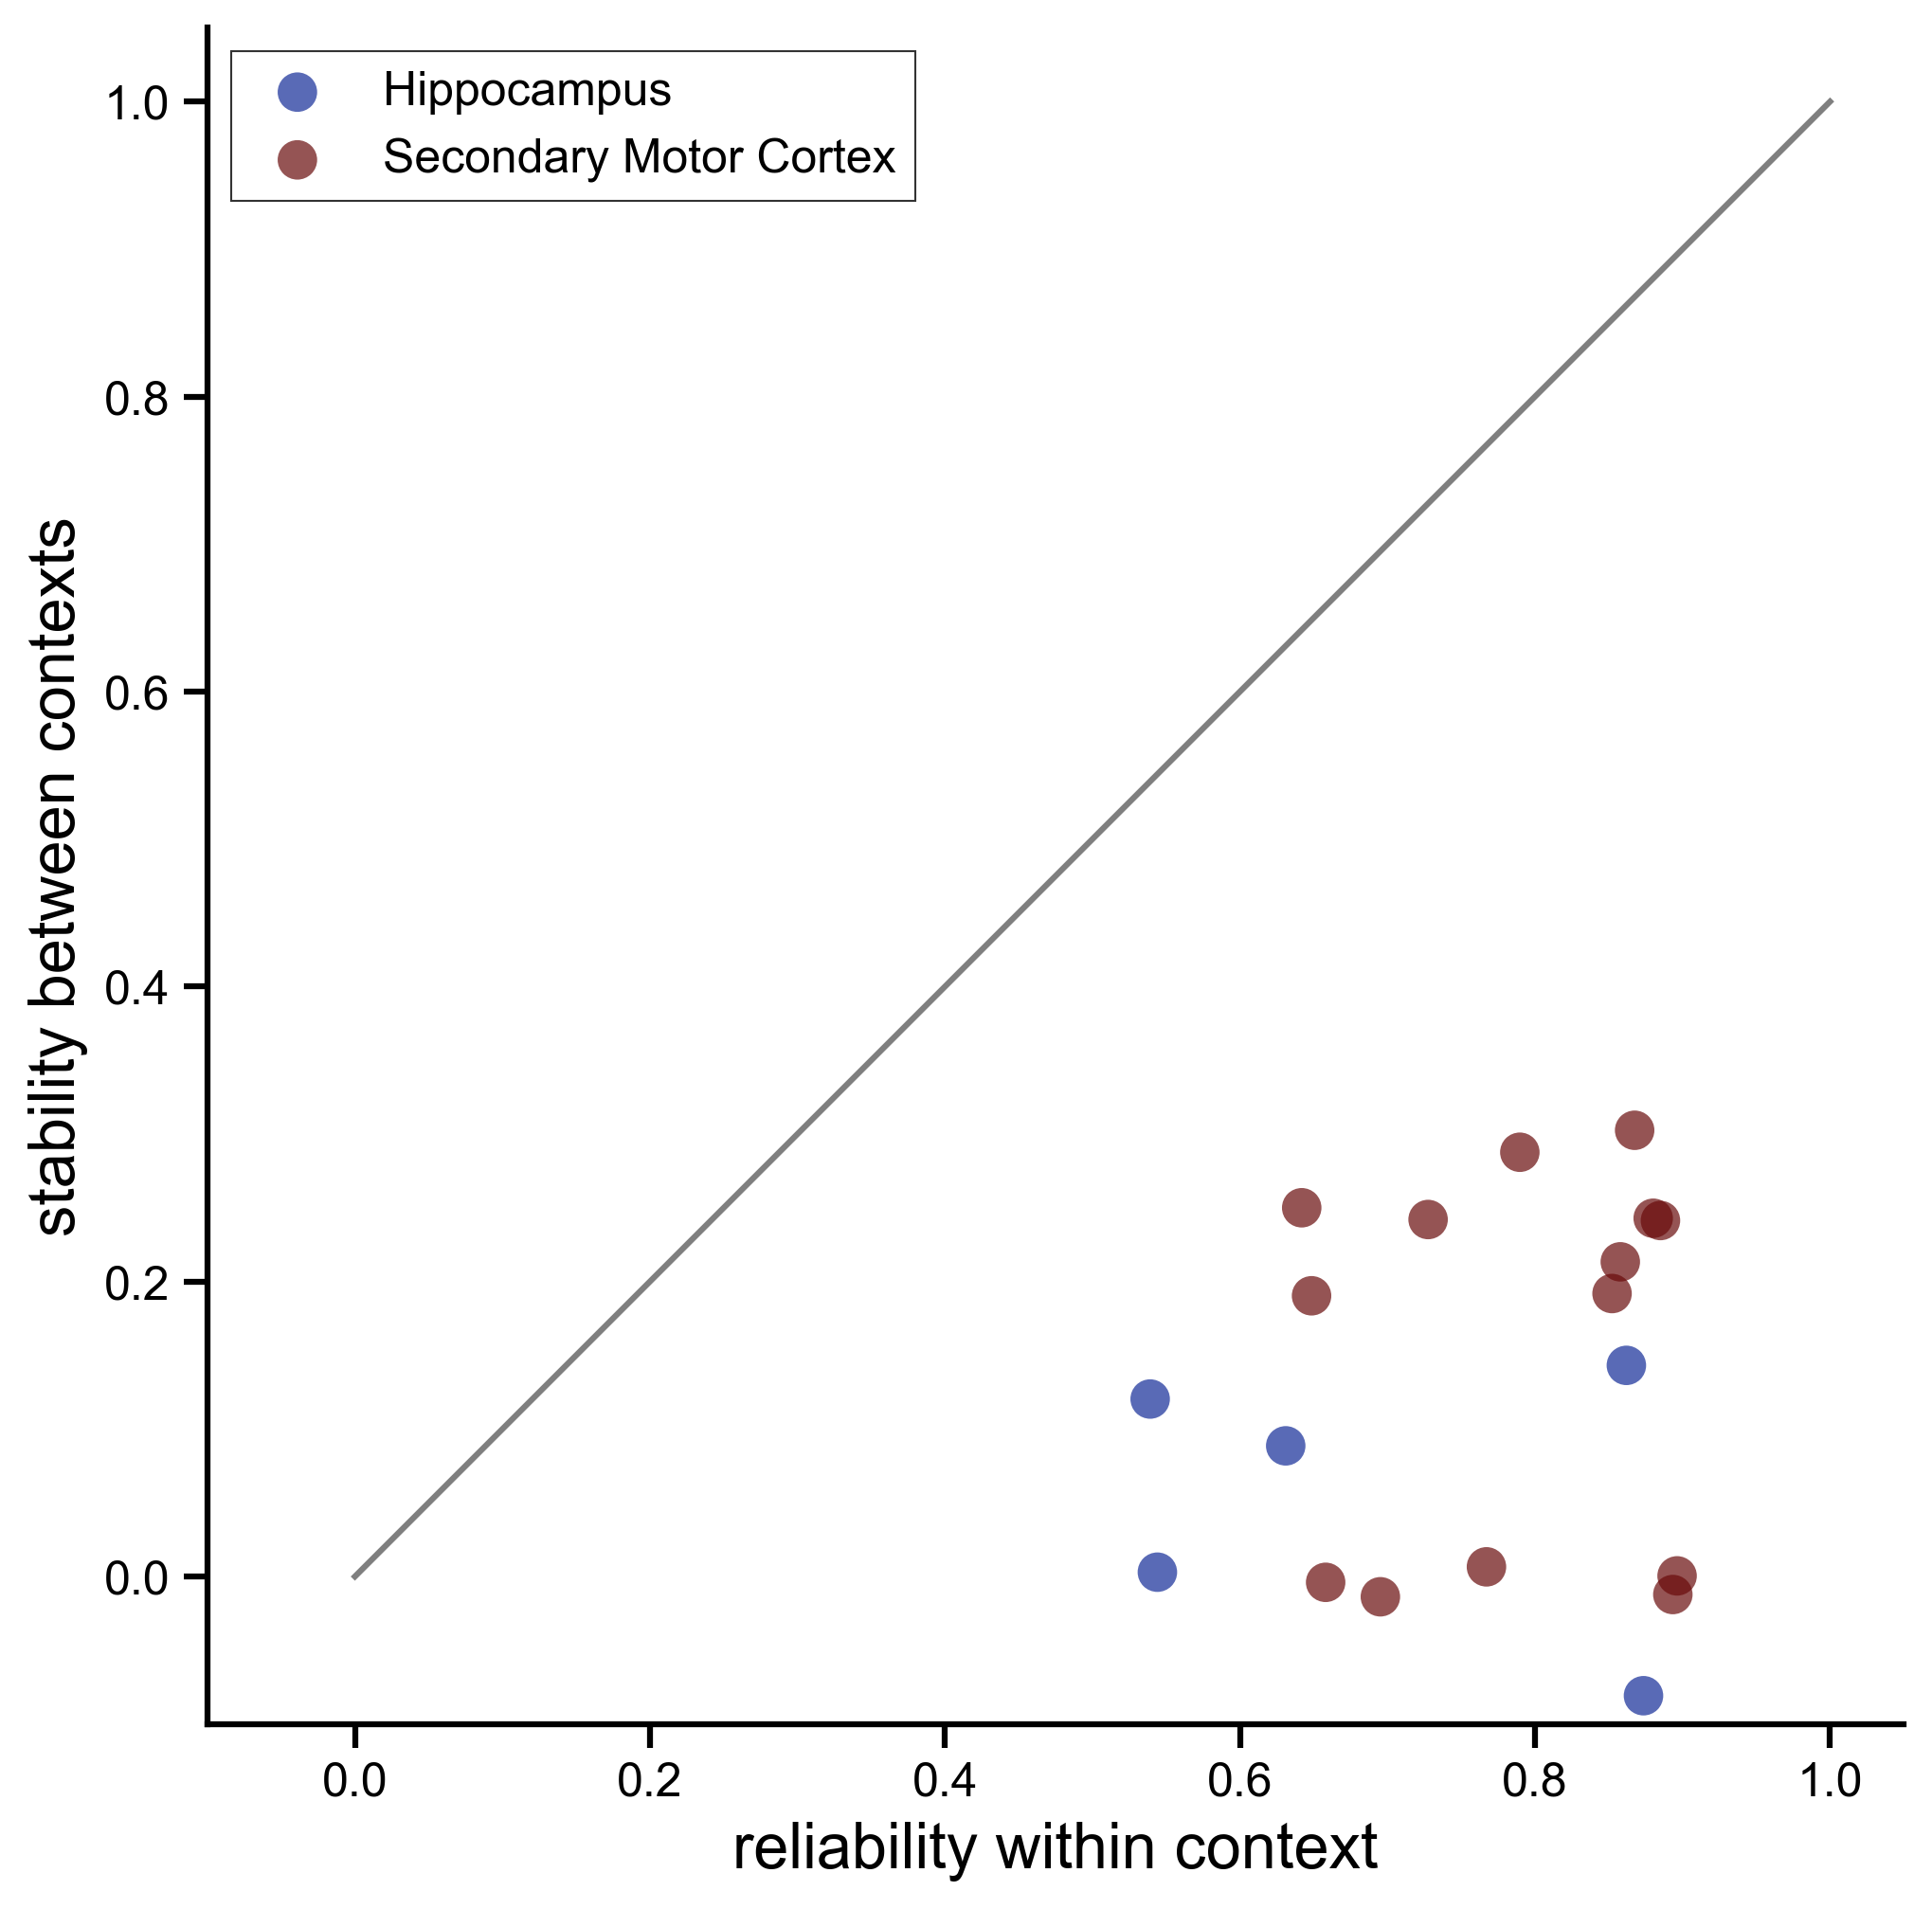

In [23]:
plot_reliability_stability(all_sessions)

In [37]:
print(spike_counts)

[[0. 0. 0. ... 1. 0. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


In [52]:
all_dca = []

for session in all_sessions:
    dca = train_decoder(session)
    test_decoder_within_context(dca)
    test_decoder_cross_context(dca)
    compare_within_cross_context_decoding(dca)
    calculate_weight_vector_cosine_similarity(dca)
    calculate_r2_leaveout(dca)
    all_dca.append(dca)


In [54]:
median = np.median([all_dca.r2_oa_leavout_oa[~np.isnan(session.r_oa)] for session in all_sessions])

AttributeError: 'list' object has no attribute 'r2_oa_leavout_oa'

In [46]:

median_oa_leaveout_oa = np.median(dca.r2_oa_leaveout_oa)

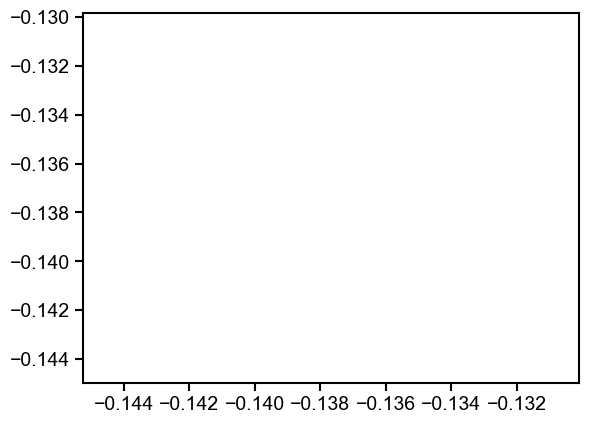

In [50]:
plt.plot(dca.r2_oa_leaveout_oa[1], dca.r2_oa_leaveout_wh[1])

In [ ]:
leaveout_oa = [dca.r_oa[~np.isnan(session.r_oa)] for session in all_sessions]

In [426]:
for session in all_sessions:
    n_neurons = session.spike_counts.shape[0]

    oa_speed_bins = np.linspace(0, np.nanmax(session.oa_speed), num=10)
    oa_speed_bin_centers = 0.5 * (oa_speed_bins[:-1] + oa_speed_bins[1:])
    wh_speed_bins = np.linspace(0, np.nanmax(session.wh_speed), num=10)
    wh_speed_bin_centers = 0.5 * (wh_speed_bins[:-1] + wh_speed_bins[1:])


    oa_firing_rates = np.zeros((n_neurons, len(oa_speed_bin_centers)))
    oa_speed_indices = np.digitize(session.oa_speed, oa_speed_bins) -1
    wh_firing_rates = np.zeros((n_neurons, len(wh_speed_bin_centers)))
    wh_speed_indices = np.digitize(session.wh_speed, wh_speed_bins) -1

    dt = 0.1


    for i in range (len(oa_speed_bin_centers)):
        idx =oa_speed_indices == i
        if np.any(idx):
            occupancy = np.sum(idx) * dt
            spikes_in_bin = session.spike_counts[:,idx].sum(axis=1)
            oa_firing_rates[:,i] = spikes_in_bin / occupancy
        else:
            oa_firing_rates[:,i] = np.nan


    for i in range (len(wh_speed_bin_centers)):
        idx =wh_speed_indices == i
        if np.any(idx):
            occupancy = np.sum(idx) * dt
            spikes_in_bin = session.spike_counts[:,idx].sum(axis=1)
            wh_firing_rates[:,i] = spikes_in_bin / occupancy
        else:
            wh_firing_rates[:,i] = np.nan

    slopes_oa = np.zeros(n_neurons)
    offsets_oa = np.zeros(n_neurons)
    r2_oa = np.zeros(n_neurons)
    slopes_wh = np.zeros(n_neurons)
    offsets_wh = np.zeros(n_neurons)
    r2_wh = np.zeros(n_neurons)

    for neuron in range(n_neurons):

        valid_oa = ~np.isnan(oa_firing_rates[neuron])
        valid_wh = ~np.isnan(wh_firing_rates[neuron])

        if np.sum(valid_oa) > 3:
            slopes_oa[neuron], offsets_oa[neuron] = np.polyfit(oa_speed_bin_centers[valid_oa], oa_firing_rates[neuron, valid_oa], 1)
            r2_oa[neuron] =1 - np.sum((oa_firing_rates[neuron, valid_oa] - (slopes_oa[neuron] * oa_speed_bin_centers[valid_oa] + offsets_oa[neuron]))**2) / np.sum((oa_firing_rates[neuron, valid_oa] - np.nanmean(oa_firing_rates[neuron, valid_oa]))**2)
        
        else:
            slopes_oa[neuron] = np.nan
            offsets_oa[neuron] = np.nan
            r2_oa[neuron] = np.nan

        if np.sum(valid_wh) > 3:
            slopes_wh[neuron], offsets_wh[neuron] = np.polyfit(wh_speed_bin_centers[valid_wh], wh_firing_rates[neuron, valid_wh], 1)
            r2_wh[neuron] =1 - np.sum((wh_firing_rates[neuron, valid_wh] - (slopes_wh[neuron] * wh_speed_bin_centers[valid_wh] + offsets_wh[neuron]))**2) / np.sum((wh_firing_rates[neuron, valid_wh] - np.nanmean(wh_firing_rates[neuron, valid_wh]))**2)
        
        else:
            slopes_wh[neuron] = np.nan
            offsets_wh[neuron] = np.nan
            r2_wh[neuron] = np.nan

    session.oa_slope = slopes_oa
    session.oa_offset = offsets_oa
    session.oa_r2 = r2_oa
    session.wh_slope = slopes_wh
    session.wh_offset = offsets_wh
    session.wh_r2 = r2_wh


In [ ]:
for session in all_sessions:
    n_neurons = session.spike_counts.shape[0]

slopes_oa = np.zeros(n_neurons)
offsets_oa = np.zeros(n_neurons)
r2_oa = np.zeros(n_neurons)
slopes_wh = np.zeros(n_neurons)
offsets_wh = np.zeros(n_neurons)
r2_wh = np.zeros(n_neurons)

for neuron in range(n_neurons):

    valid_oa = ~np.isnan(oa_firing_rates[neuron])
    valid_wh = ~np.isnan(wh_firing_rates[neuron])

    if np.sum(valid_oa) > 3:
        slopes_oa[neuron], offsets_oa[neuron] = np.polyfit(oa_speed_bin_centers[valid_oa], oa_firing_rates[neuron, valid_oa], 1)
        r2_oa[neuron] =1 - np.sum((oa_firing_rates[neuron, valid_oa] - (slopes_oa[neuron] * oa_speed_bin_centers[valid_oa] + offsets_oa[neuron]))**2) / np.sum((oa_firing_rates[neuron, valid_oa] - np.nanmean(oa_firing_rates[neuron, valid_oa]))**2)
        
    else:
        slopes_oa[neuron] = np.nan
        offsets_oa[neuron] = np.nan
        r2_oa[neuron] = np.nan

    if np.sum(valid_wh) > 3:
        slopes_wh[neuron], offsets_wh[neuron] = np.polyfit(wh_speed_bin_centers[valid_wh], wh_firing_rates[neuron, valid_wh], 1)
        r2_wh[neuron] =1 - np.sum((wh_firing_rates[neuron, valid_wh] - (slopes_wh[neuron] * wh_speed_bin_centers[valid_wh] + offsets_wh[neuron]))**2) / np.sum((wh_firing_rates[neuron, valid_wh] - np.nanmean(wh_firing_rates[neuron, valid_wh]))**2)
        
    else:
        slopes_wh[neuron] = np.nan
        offsets_wh[neuron] = np.nan
        r2_wh[neuron] = np.nan

    session.oa_slope = slopes_oa
    session.oa_offset = offsets_oa
    session.oa_r2 = r2_oa
    session.wh_slope = slopes_wh
    session.wh_offset = offsets_wh
    session.wh_r2 = r2_wh


In [526]:
explore = all_sessions[7]
subject_id = explore.subject_id
date = explore.date
print(f"Exploring session for {subject_id} on {date}")

Exploring session for EB037 on 2024-03-20


Text(0.5, 1.0, 'Intercept Comparison')

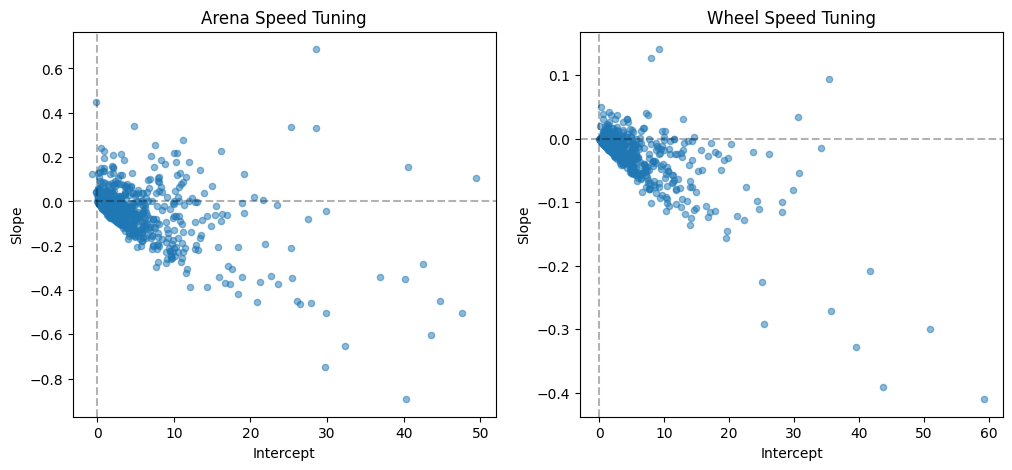

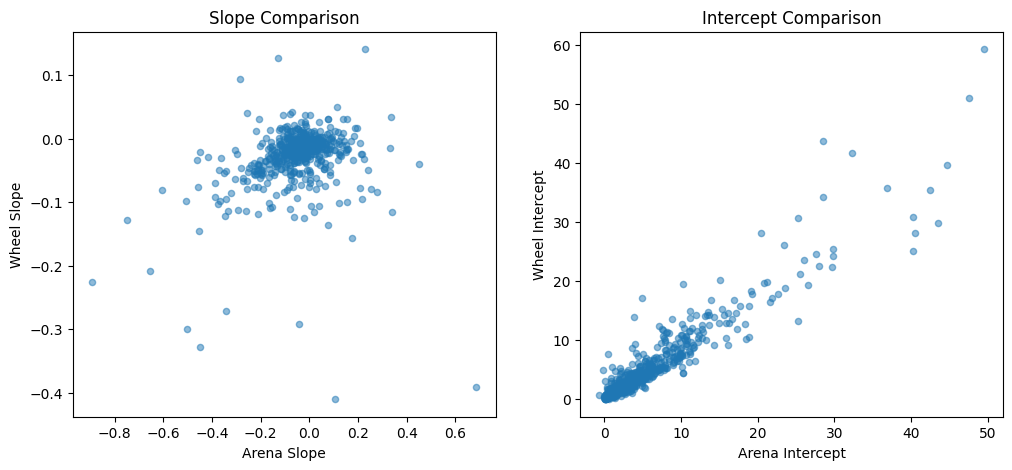

In [518]:



    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

#well_fit = (explore.oa_r2 > 0.5) | (explore.wh_r2 > 0.5)

# Arena tuning
ax1.scatter(explore.oa_offset, explore.oa_slope, alpha=0.5, s=20)
ax1.axhline(0, color='k', linestyle='--', alpha=0.3)
ax1.axvline(0, color='k', linestyle='--', alpha=0.3)
ax1.set_xlabel('Intercept')
ax1.set_ylabel('Slope')
ax1.set_title('Arena Speed Tuning')

# Wheel tuning
ax2.scatter(explore.wh_offset, explore.wh_slope, alpha=0.5, s=20)
ax2.axhline(0, color='k', linestyle='--', alpha=0.3)
ax2.axvline(0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel('Intercept')
ax2.set_ylabel('Slope')
ax2.set_title('Wheel Speed Tuning')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Compare slopes across contexts
ax1.scatter(explore.oa_slope, explore.wh_slope, alpha=0.5, s=20)
ax1.set_xlabel('Arena Slope')
ax1.set_ylabel('Wheel Slope')
ax1.set_title('Slope Comparison')

# Compare offsets across contexts
ax2.scatter(explore.oa_offset, explore.wh_offset, alpha=0.5, s=20)
ax2.set_xlabel('Arena Intercept')
ax2.set_ylabel('Wheel Intercept')
ax2.set_title('Intercept Comparison')



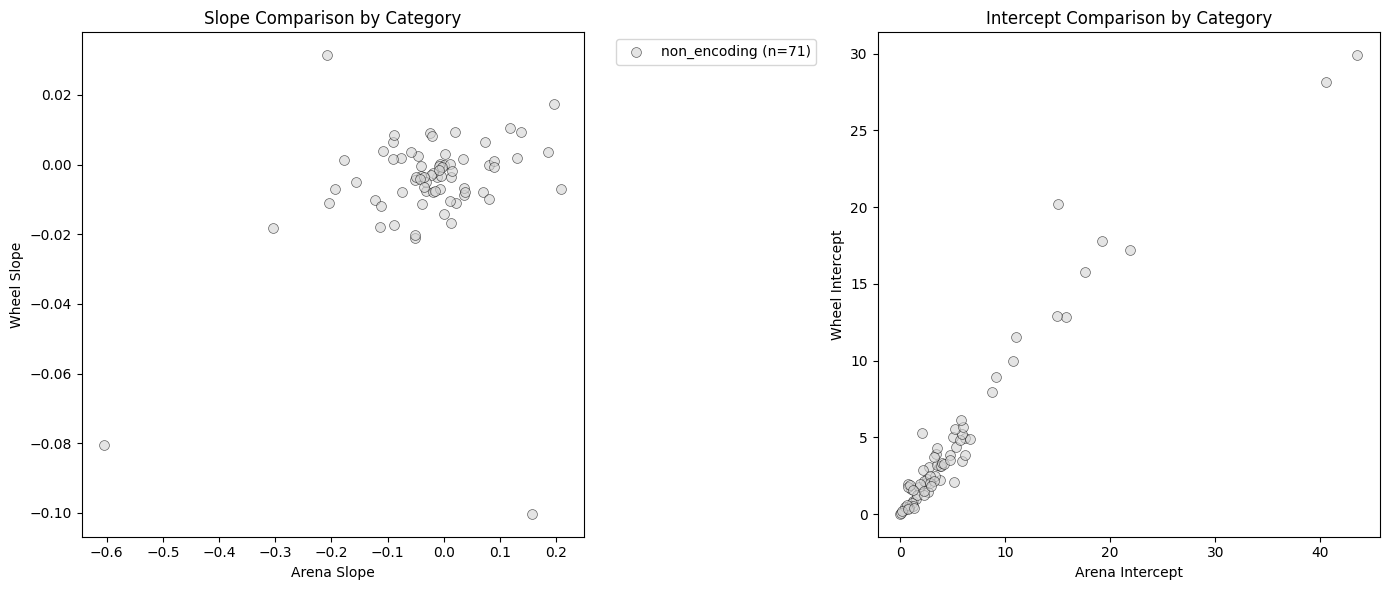

In [524]:
# Define colors for each category
colors = {
    #'context_invariant': 'black',
    #'arena_only': 'green', 
    #'wheel_only': 'purple',
    #'context_switching': 'orange',
    'non_encoding': 'lightgray'
}


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot each category separately
for cat, color in colors.items():
    if hasattr(explore, cat):
        mask = getattr(explore, cat) #& well_fit
        if np.sum(mask) > 0:
            ax1.scatter(explore.oa_slope[mask], explore.wh_slope[mask], 
                       c=color, label=f'{cat} (n={np.sum(mask)})', 
                       alpha=0.6, s=50, edgecolor='k', linewidth=0.5)

            ax2.scatter(explore.oa_offset[mask], explore.wh_offset[mask], 
                       c=color, alpha=0.6, s=50, edgecolor='k', linewidth=0.5)


ax1.set_xlabel('Arena Slope')
ax1.set_ylabel('Wheel Slope')
ax1.set_title('Slope Comparison by Category')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

max_offset = np.nanmax(np.concatenate([explore.oa_offset, explore.wh_offset]))
ax2.set_xlabel('Arena Intercept')
ax2.set_ylabel('Wheel Intercept')
ax2.set_title('Intercept Comparison by Category')

plt.tight_layout()

In [120]:

def get_reliability_Stability(session):

        r_oa_1= session.r_oa_first_half
        r_oa_2 = session.r_oa_second_half
        r_wh_1= session.r_wh_first_half
        r_wh_2= session.r_wh_second_half
        r_oa_1_2 = session.oa_stability
        r_wh_1_2 = session.wh_stability


        r_oa_1_wh_2 = np.corrcoef(r_oa_1, r_wh_2) [0,1]
        r_oa_2_wh_1 = np.corrcoef(r_oa_2, r_wh_1) [0,1]


        session.reliability = np.sqrt(r_oa_1_2* r_wh_1_2) 

        
        z1 = np.arctanh(r_oa_1_wh_2)
        z2 = np.arctanh(r_oa_2_wh_1)

        z_mean = (z1 + z2 ) / 2
        session.stability = np.tanh(z_mean)

In [ ]:
def plot_reliability_stability(all_session):
    
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams['xtick.major.width'] = 1.5
    plt.rcParams['ytick.major.width'] = 1.5
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['ytick.major.size'] = 6

    fig, ax = plt.subplots(1, 1, figsize=(7, 7), dpi=300)

    reliability_values = []
    stability_values = []
    brain_regions = []

    for session in all_sessions:
        
        reliability_values.append(session.reliability)
        stability_values.append(session.stability)
        
    
        if session.subject_id[:2] == 'EB':
            brain_regions.append('Hippocampus')
        else:
            brain_regions.append('Secondary Motor Cortex')


    reliability_values = np.array(reliability_values)
    stability_values = np.array(stability_values)
    brain_regions = np.array(brain_regions)


    colors = {
        'Hippocampus':"#132B97",  
        'Secondary Motor Cortex':"#690B0B" 
    }  
    for region in ['Hippocampus', 'Secondary Motor Cortex']:
        mask = brain_regions == region
        
        ax.scatter(reliability_values[mask], 
                stability_values[mask], 
                c=colors[region],
                s=100,  
                alpha=0.7,  
                edgecolors='none',  
                linewidth=0.5,
                label=region,
                zorder=3)

    ax.plot([0, 1], [0, 1], 'k-', linewidth=1.5, alpha=0.5, zorder=1)

    ax.set_xlim(-0.10, 1.05)
    ax.set_ylim(-0.10, 1.05)

    ax.set_xlabel('reliability within context', fontsize=16)
    ax.set_ylabel('stability between contexts', fontsize=16)

    # Add legend
    legend = ax.legend(loc='upper left', 
                    frameon=True, 
                    fancybox=False,
                    edgecolor='black',
                    fontsize=12)
    legend.get_frame().set_linewidth(0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6)


    ax.set_aspect('equal', adjustable='box')

    plt.tight_layout()

In [118]:
sesh =load_and_process_session(subject_id, date, target_freq=10)
sesh = analyze_single_session(sesh)


(array([], dtype=int64),)
DEBUG: n_neurons = 819
DEBUG: Arena mask sum = 39258 / 55129 time points
DEBUG: Wheel mask sum = 15642 / 55129 time points
DEBUG: Arena speed shape = (55129,), unique values = 55128
DEBUG: Wheel speed shape = (55129,), unique values = 26849
DEBUG: Total spikes in arena = 7629167.0
DEBUG: Total spikes in wheel = 3318447.0
DEBUG: Neurons with arena variance > 0: 819
DEBUG: Neurons with wheel variance > 0: 819
DEBUG: Good neurons = 819 / 819
DEBUG: r_oa NaNs = 0
DEBUG: r_wh NaNs = 0
DEBUG: r_oa range = [-0.186, 0.320]
DEBUG: r_wh range = [-0.344, 0.370]
DEBUG: Arena speed variance = 7.94207171427573
DEBUG: Wheel speed variance = 143.90923496567723


NameError: name 'all_sessions' is not defined

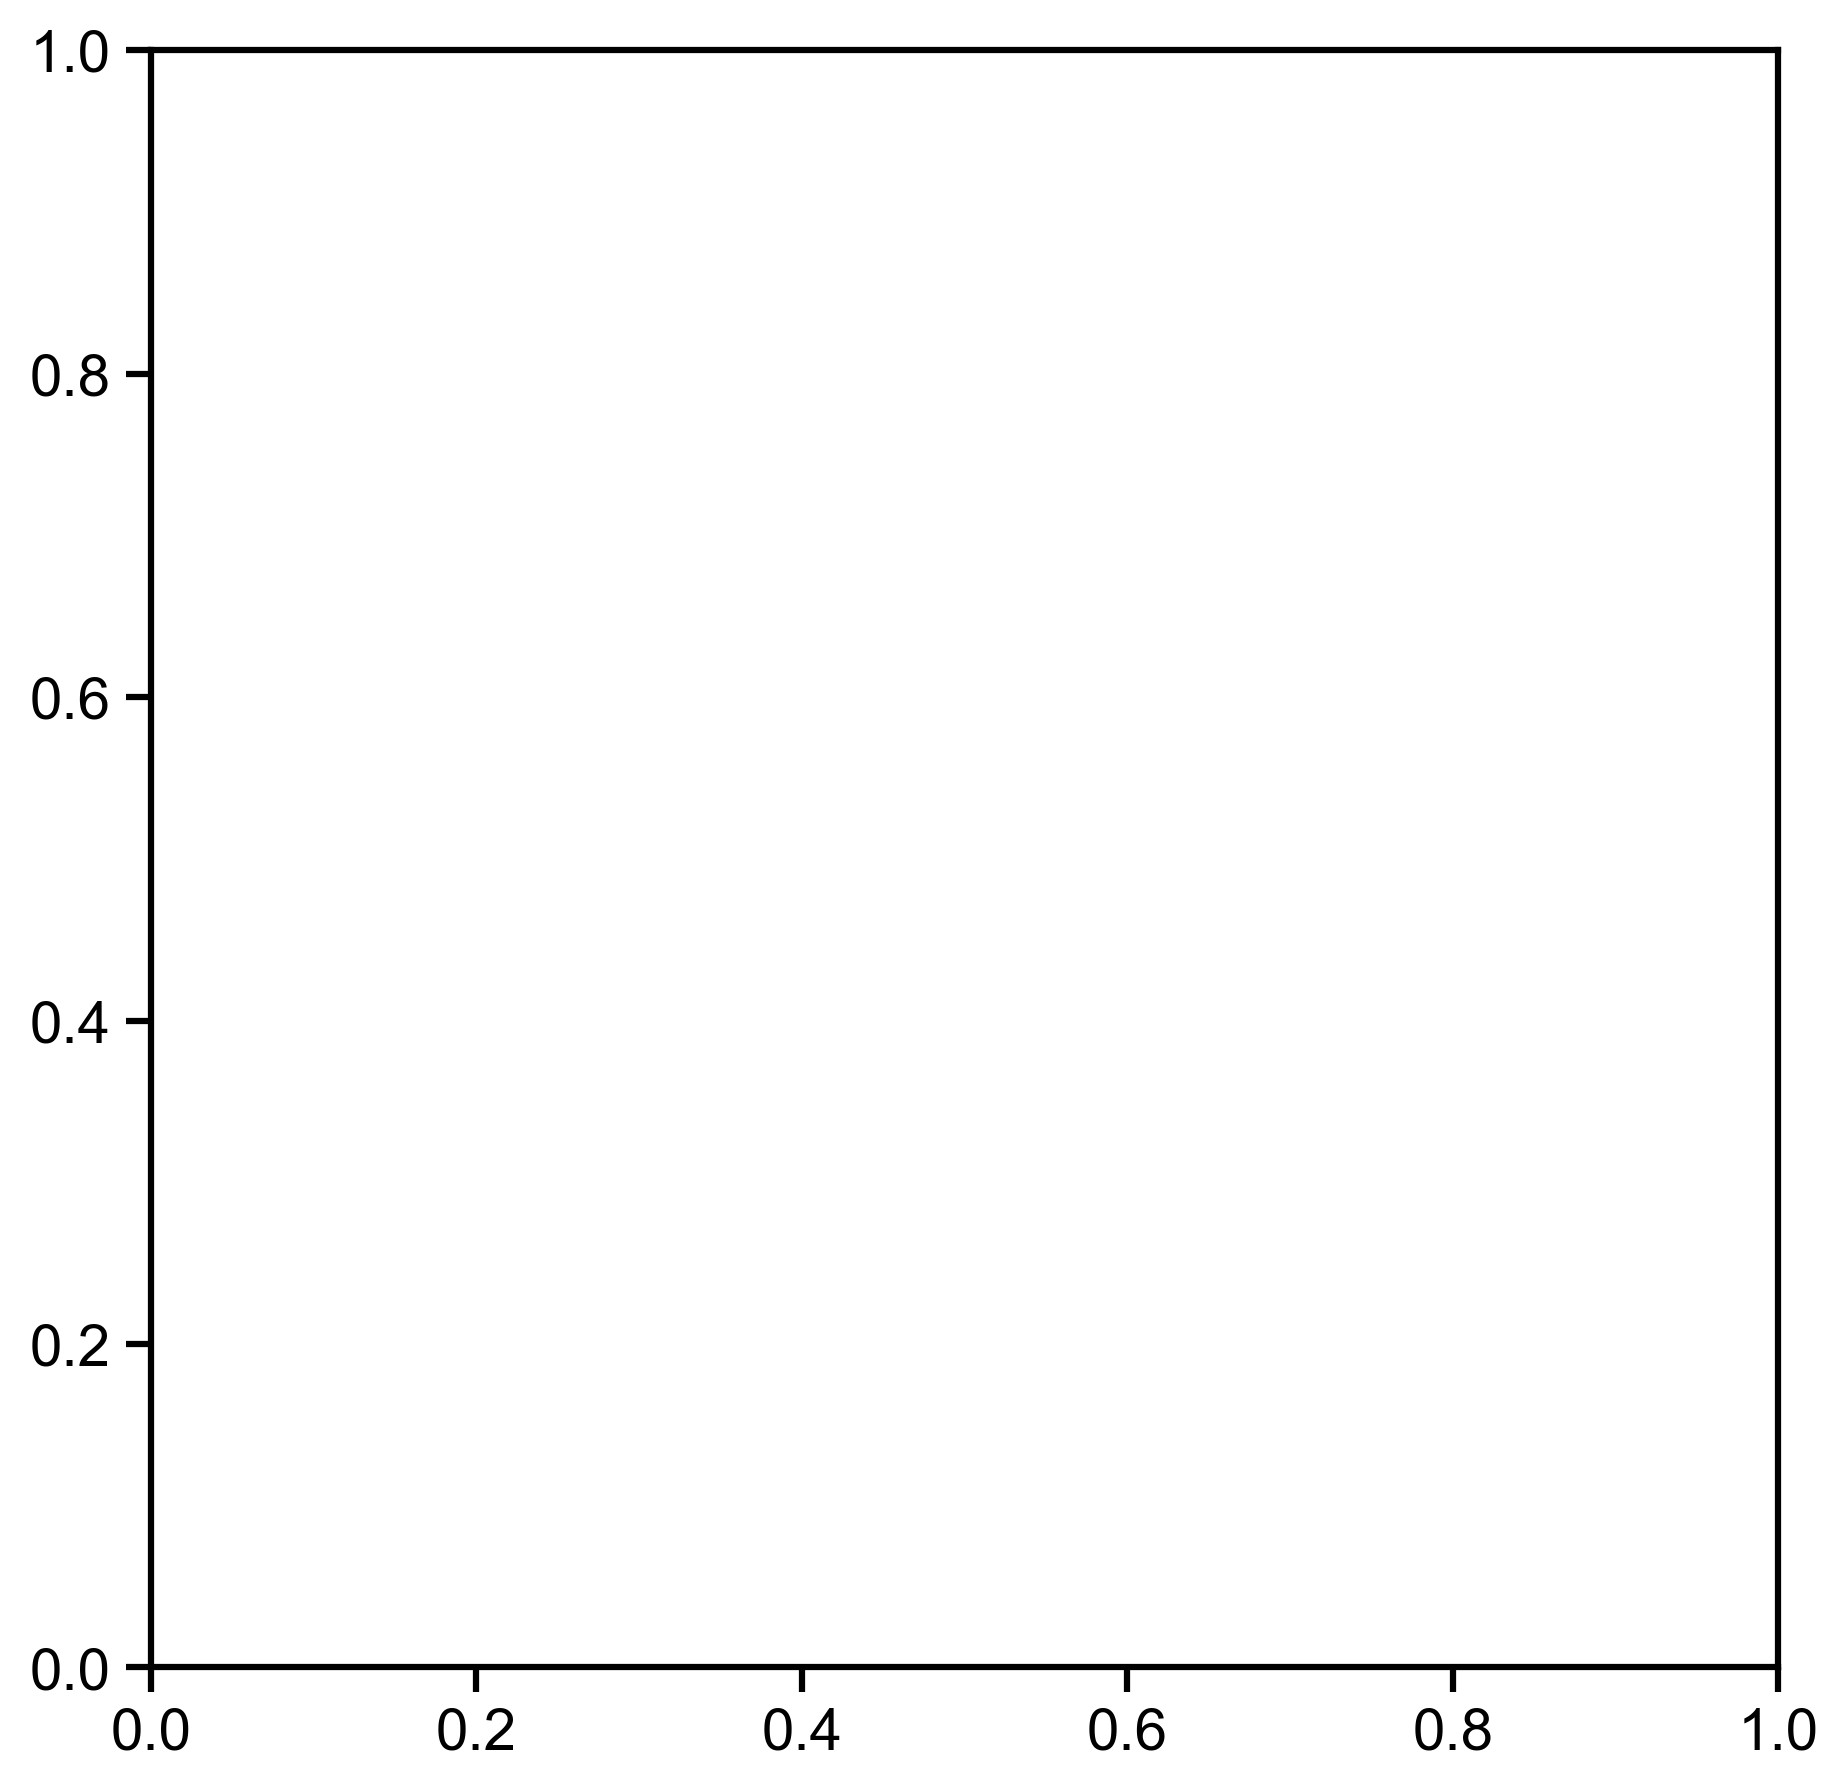

In [124]:
get_reliability_Stability(sesh)
plot_reliability_stability(sesh)


neck: 482 NaN frames for x (0.3%)
neck: 482 NaN frames for y (0.3%)
mid_back: 1371 NaN frames for x (0.9%)
mid_back: 1371 NaN frames for y (0.9%)
mouse_center: 206 NaN frames for x (0.1%)
mouse_center: 206 NaN frames for y (0.1%)
mid_backend: 460 NaN frames for x (0.3%)
mid_backend: 460 NaN frames for y (0.3%)
mid_backend2: 1770 NaN frames for x (1.2%)
mid_backend2: 1770 NaN frames for y (1.2%)
mid_backend3: 2292 NaN frames for x (1.5%)
mid_backend3: 2292 NaN frames for y (1.5%)


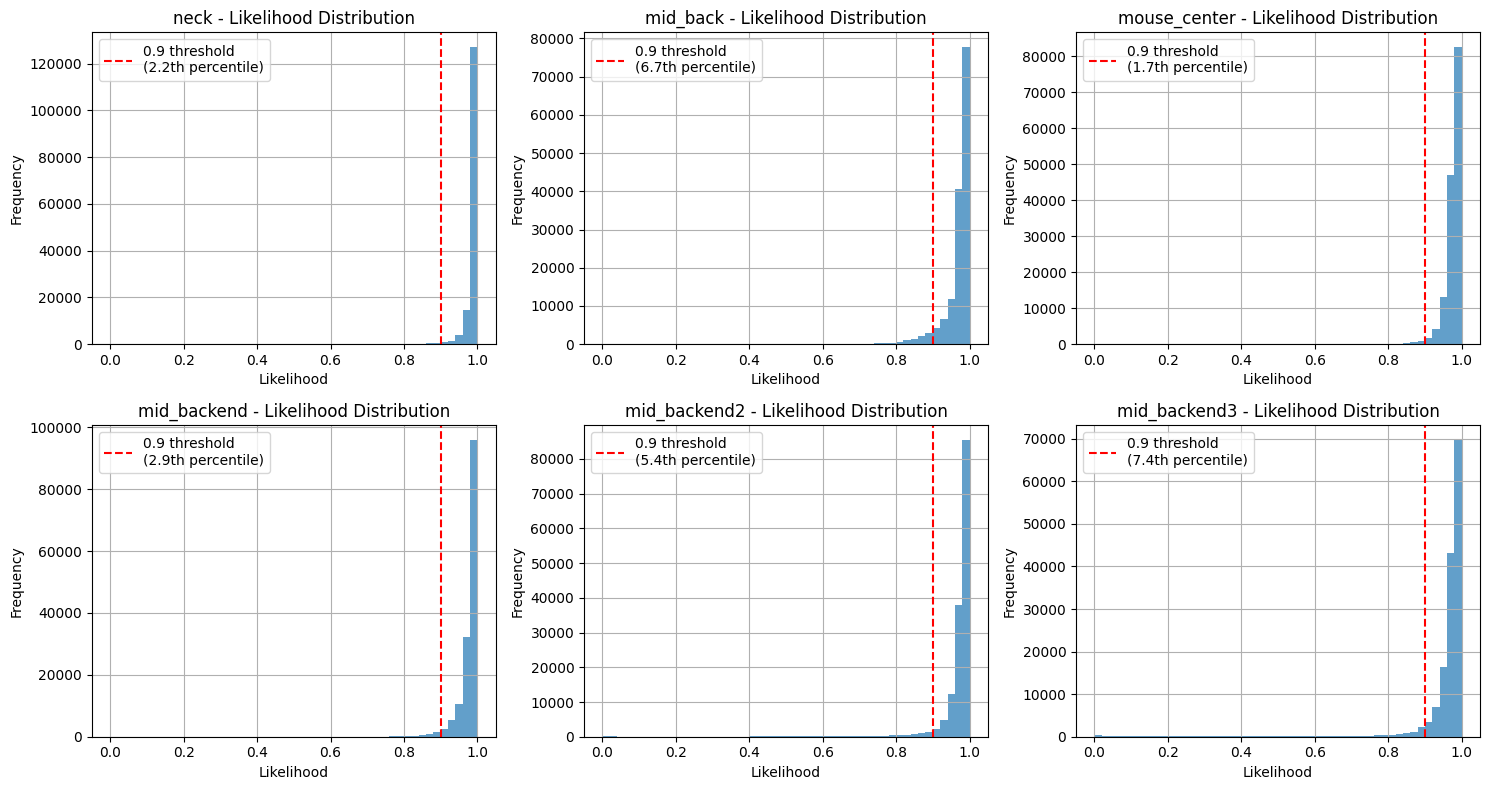

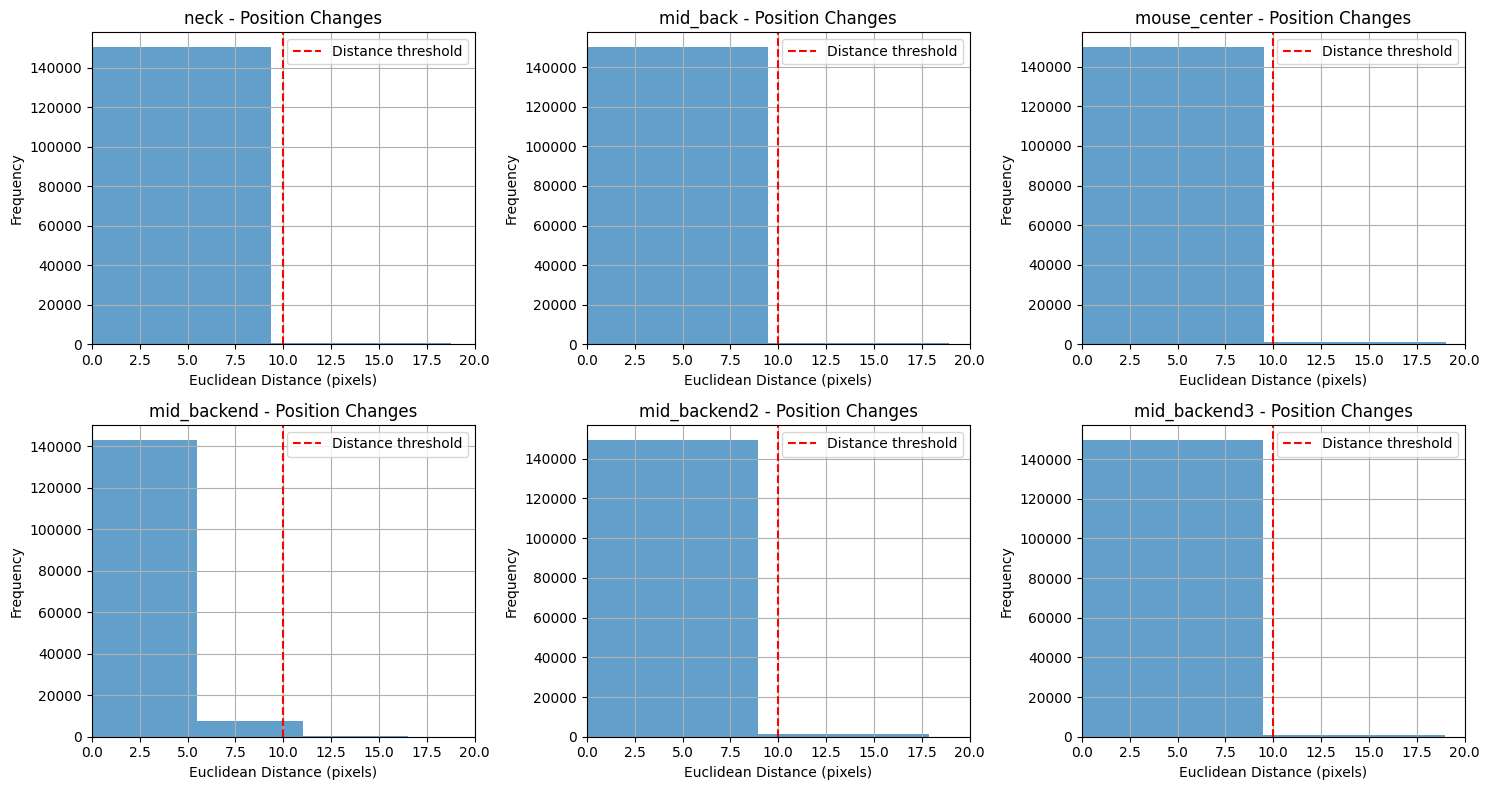

neck: 482 NaN frames for x (0.3%)
neck: 482 NaN frames for y (0.3%)
mid_back: 1371 NaN frames for x (0.9%)
mid_back: 1371 NaN frames for y (0.9%)
mouse_center: 206 NaN frames for x (0.1%)
mouse_center: 206 NaN frames for y (0.1%)
mid_backend: 460 NaN frames for x (0.3%)
mid_backend: 460 NaN frames for y (0.3%)
mid_backend2: 1770 NaN frames for x (1.2%)
mid_backend2: 1770 NaN frames for y (1.2%)
mid_backend3: 2292 NaN frames for x (1.5%)
mid_backend3: 2292 NaN frames for y (1.5%)


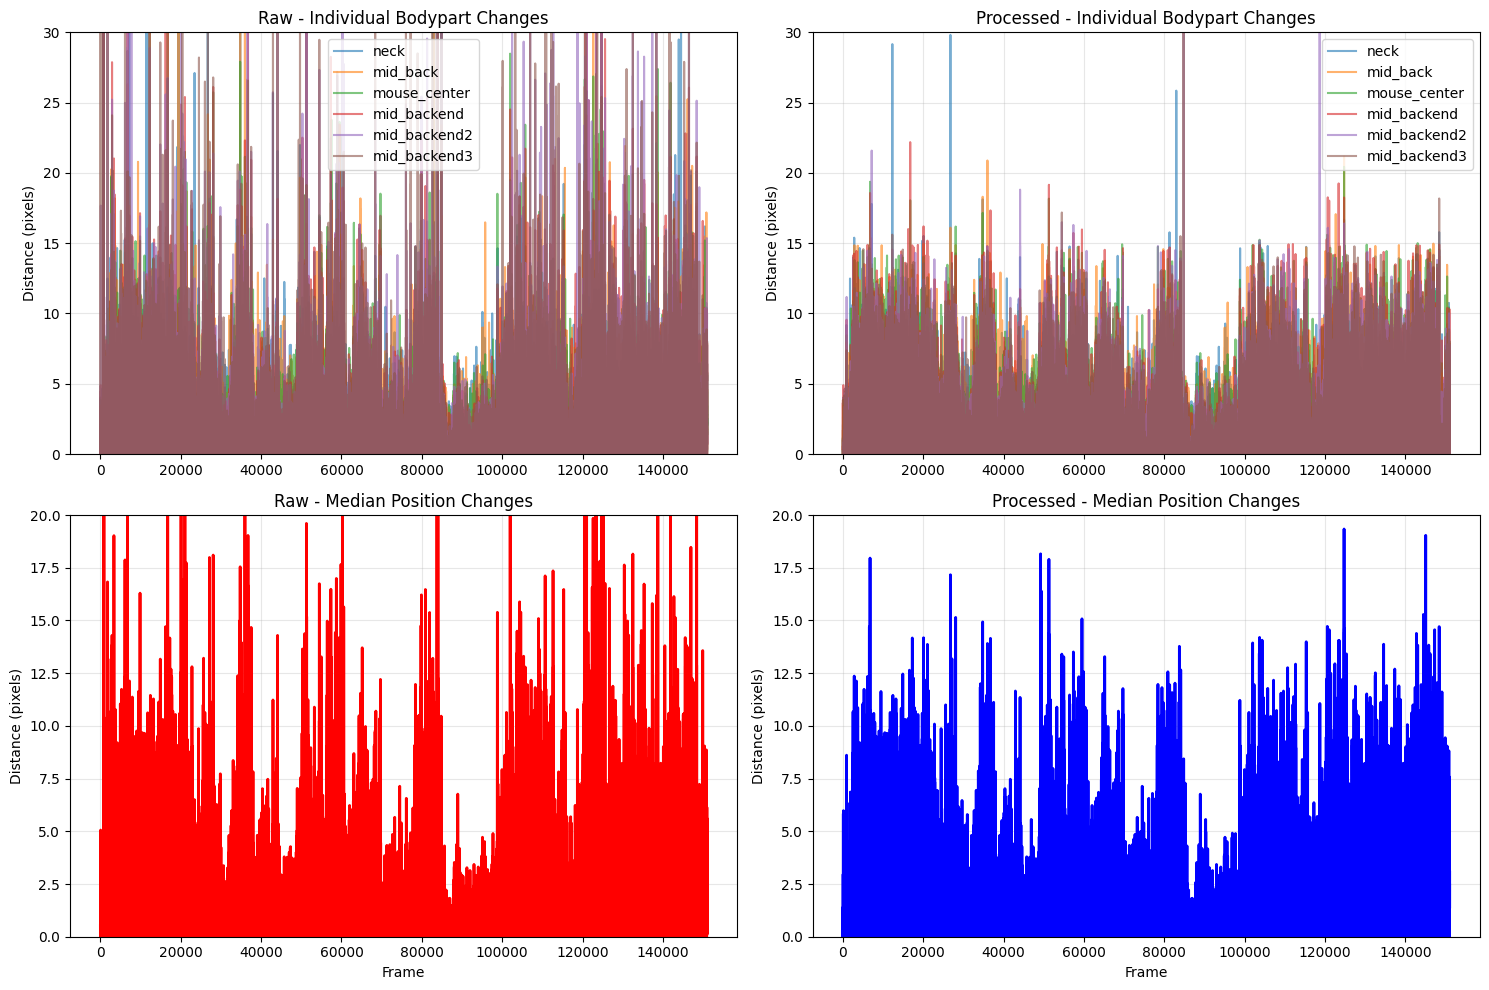

In [12]:
dlc_df = get_dlc_df(subject_id, date)
preprocess_dlc_data(dlc_df)
plot_dlc_analyses(dlc_df, w_start=0, w_end=400000)